### Imports et configuration générale

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import time
from sklearn.preprocessing import StandardScaler
import pandas as pd



###  Chargement et préparation des données

In [2]:
# Load dataset
data = load_breast_cancer()
X_raw = data.data
y = data.target * 2 - 1

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
n, d = X.shape
print(f"Dataset shape: n={n}, d={d}")


Dataset shape: n=569, d=30


In [3]:
# presentation et statistiques du dataset

df = pd.DataFrame(data=X_raw, columns=data.feature_names)
df['target'] = y
# show description statistics of the dataset in a table
df.describe()
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,-1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,-1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,-1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,-1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,-1


### Fonctions loss & gradient (logistique + régularisation L2)

In [4]:
# Define logistic loss and gradient
def logistic_loss(w, X, y, lambda_reg=0.1):
    z = y * (X @ w)
    loss = np.mean(np.log(1 + np.exp(-z))) + (lambda_reg / 2) * np.linalg.norm(w)**2
    return loss

def logistic_gradient(w, X, y, lambda_reg=0.1):
    z = y * (X @ w)
    sig = 1 / (1 + np.exp(z))  # sigma(y * Xw) = 1 / (1 + exp(- (-y Xw))) wait, adjust
    # Correct: sigma(-y Xw) = 1 / (1 + exp(-y Xw))
    exp_term = np.exp(-z)
    sig_minus = exp_term / (1 + exp_term)
    grad = - (1/n) * (X.T @ (y * sig_minus)) + lambda_reg * w
    return grad

# Compute L
lambda_reg = 0.1
eigvals = np.linalg.eigvalsh(X.T @ X)
L = lambda_reg + (1 / (4 * n)) * np.max(eigvals)
print(f"L = {L}")

L = 3.420401920564474


### Gradient Descent à pas fixe (GD)

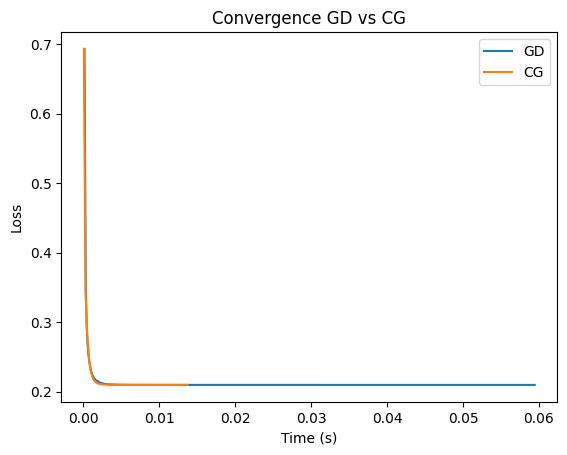

In [5]:
# Gradient Descent (GD)
def gd_fixed_step(X, y, lambda_reg, alpha, max_iter=1000, tol=1e-6):
    w = np.zeros(d)
    losses = []
    times = []
    start_time = time.time()
    for k in range(max_iter):
        loss = logistic_loss(w, X, y, lambda_reg)
        losses.append(loss)
        times.append(time.time() - start_time)
        grad = logistic_gradient(w, X, y, lambda_reg)
        if np.linalg.norm(grad) < tol:
            break
        w -= alpha * grad
    return w, losses, times

# Nonlinear Conjugate Gradient (Fletcher-Reeves)
def cg_nonlinear(X, y, lambda_reg, max_iter=1000, tol=1e-6):
    w = np.zeros(d)
    grad = logistic_gradient(w, X, y, lambda_reg)
    d_dir = -grad
    losses = []
    times = []
    start_time = time.time()
    for k in range(max_iter):
        loss = logistic_loss(w, X, y, lambda_reg)
        losses.append(loss)
        times.append(time.time() - start_time)
        if np.linalg.norm(grad) < tol:
            break
        # Line search (simple fixed step for simplicity, but ideally backtracking)
        alpha = 1 / L  # Approximate
        w_new = w + alpha * d_dir
        grad_new = logistic_gradient(w_new, X, y, lambda_reg)
        beta = np.dot(grad_new, grad_new) / np.dot(grad, grad)
        d_dir = -grad_new + beta * d_dir
        w = w_new
        grad = grad_new
    return w, losses, times

# Run and plot
alpha = 1 / L
w_gd, losses_gd, times_gd = gd_fixed_step(X, y, lambda_reg, alpha)
w_cg, losses_cg, times_cg = cg_nonlinear(X, y, lambda_reg)

plt.plot(times_gd, losses_gd, label='GD')
plt.plot(times_cg, losses_cg, label='CG')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.legend()
plt.title('Convergence GD vs CG')
plt.show()

### L’Échelle Stochastique

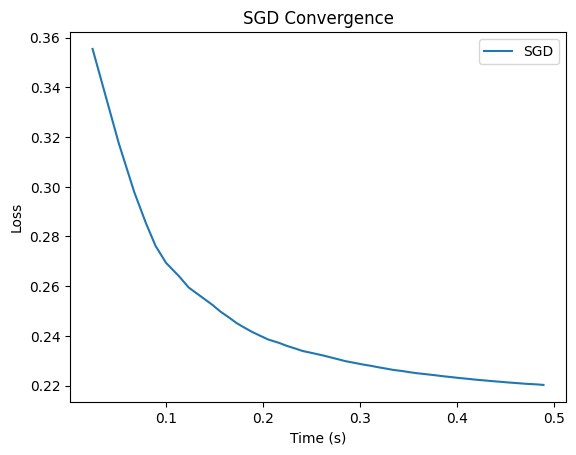

In [6]:
# Stochastic Gradient Descent (SGD)
def sgd_decreasing_step(X, y, lambda_reg, alpha0, max_epochs=50):
    w = np.zeros(d)
    losses = []
    times = []
    start_time = time.time()
    for epoch in range(max_epochs):
        perm = np.random.permutation(n)
        for i in perm:
            k = epoch * n + i + 1  # iteration count
            alpha_k = alpha0 / np.sqrt(k)
            xi, yi = X[i], y[i]
            z = yi * np.dot(xi, w)
            sig_minus = np.exp(-z) / (1 + np.exp(-z))
            grad_i = - yi * xi * sig_minus + lambda_reg * w
            w -= alpha_k * grad_i
        loss = logistic_loss(w, X, y, lambda_reg)
        losses.append(loss)
        times.append(time.time() - start_time)
    return w, losses, times

# Run
alpha0 = 0.01
w_sgd, losses_sgd, times_sgd = sgd_decreasing_step(X, y, lambda_reg, alpha0)

plt.plot(times_sgd, losses_sgd, label='SGD')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.legend()
plt.title('SGD Convergence')
plt.show()

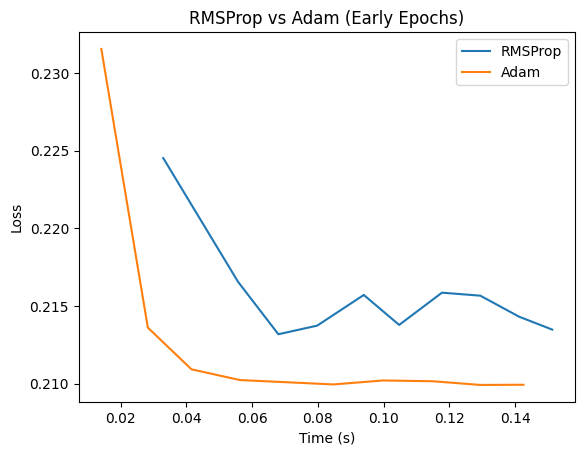

In [7]:
# RMSProp
def rmsprop(X, y, lambda_reg, alpha=0.001, beta=0.9, epsilon=1e-8, max_epochs=50):
    w = np.zeros(d)
    v = np.zeros(d)
    losses = []
    times = []
    start_time = time.time()
    for epoch in range(max_epochs):
        perm = np.random.permutation(n)
        for i in perm:
            xi, yi = X[i], y[i]
            z = yi * np.dot(xi, w)
            sig_minus = np.exp(-z) / (1 + np.exp(-z))
            grad_i = - yi * xi * sig_minus + lambda_reg * w
            v = beta * v + (1 - beta) * grad_i**2
            w -= alpha * grad_i / (np.sqrt(v) + epsilon)
        loss = logistic_loss(w, X, y, lambda_reg)
        losses.append(loss)
        times.append(time.time() - start_time)
    return w, losses, times

# Adam
def adam(X, y, lambda_reg, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, max_epochs=50):
    w = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    losses = []
    times = []
    start_time = time.time()
    t = 0
    for epoch in range(max_epochs):
        perm = np.random.permutation(n)
        for i in perm:
            t += 1
            xi, yi = X[i], y[i]
            z = yi * np.dot(xi, w)
            sig_minus = np.exp(-z) / (1 + np.exp(-z))
            grad_i = - yi * xi * sig_minus + lambda_reg * w
            m = beta1 * m + (1 - beta1) * grad_i
            v = beta2 * v + (1 - beta2) * grad_i**2
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            w -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        loss = logistic_loss(w, X, y, lambda_reg)
        losses.append(loss)
        times.append(time.time() - start_time)
    return w, losses, times

# Run and compare (first 10 epochs for early)
max_ep = 10
w_rms, losses_rms, times_rms = rmsprop(X, y, lambda_reg, max_epochs=max_ep)
w_adam, losses_adam, times_adam = adam(X, y, lambda_reg, max_epochs=max_ep)

plt.plot(times_rms, losses_rms, label='RMSProp')
plt.plot(times_adam, losses_adam, label='Adam')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.legend()
plt.title('RMSProp vs Adam (Early Epochs)')
plt.show()

### Non-Lissé, Parcimonie et Proximal 

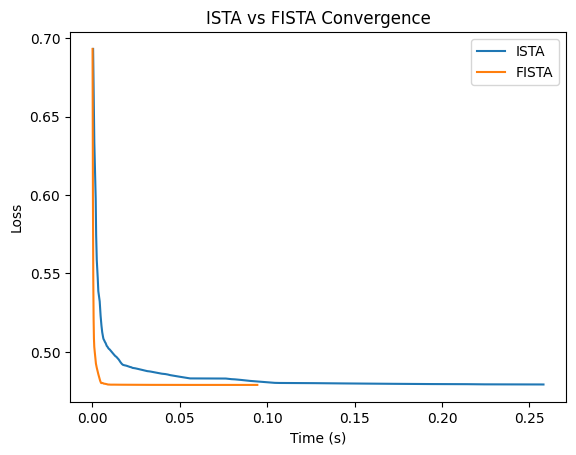

In [8]:
# Proximal operator for L1
def prox_l1(w, alpha_lambda):
    return np.sign(w) * np.maximum(np.abs(w) - alpha_lambda, 0)

# Gradient of f (logistic without ridge)
def logistic_gradient_no_reg(w, X, y):
    z = y * (X @ w)
    exp_term = np.exp(-z)
    sig_minus = exp_term / (1 + exp_term)
    grad = - (1/n) * (X.T @ (y * sig_minus))
    return grad

def logistic_loss_no_reg(w, X, y):
    z = y * (X @ w)
    loss = np.mean(np.log(1 + np.exp(-z)))
    return loss

# ISTA
def ista(X, y, lambda_l1, alpha, max_iter=1000, tol=1e-6):
    w = np.zeros(d)
    losses = []
    times = []
    start_time = time.time()
    for k in range(max_iter):
        loss = logistic_loss_no_reg(w, X, y) + lambda_l1 * np.linalg.norm(w, 1)
        losses.append(loss)
        times.append(time.time() - start_time)
        grad = logistic_gradient_no_reg(w, X, y)
        if np.linalg.norm(grad) < tol:
            break
        w_temp = w - alpha * grad
        w = prox_l1(w_temp, alpha * lambda_l1)
    return w, losses, times

# FISTA (accelerated)
def fista(X, y, lambda_l1, alpha, max_iter=1000, tol=1e-6):
    w = np.zeros(d)
    z = w.copy()
    t = 1
    losses = []
    times = []
    start_time = time.time()
    for k in range(max_iter):
        loss = logistic_loss_no_reg(w, X, y) + lambda_l1 * np.linalg.norm(w, 1)
        losses.append(loss)
        times.append(time.time() - start_time)
        grad = logistic_gradient_no_reg(z, X, y)
        if np.linalg.norm(grad) < tol:
            break
        w_new = prox_l1(z - alpha * grad, alpha * lambda_l1)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = w_new + ((t - 1) / t_new) * (w_new - w)
        w = w_new
        t = t_new
    return w, losses, times

# Run and plot
lambda_l1 = 0.1
alpha_prox = 1 / (np.max(eigvals) / n)  # Approx 1/L for f, L ~ lambda_max(X^T X)/ (4n) but without 1/4 for safety
w_ista, losses_ista, times_ista = ista(X, y, lambda_l1, alpha_prox)
w_fista, losses_fista, times_fista = fista(X, y, lambda_l1, alpha_prox)

plt.plot(times_ista, losses_ista, label='ISTA')
plt.plot(times_fista, losses_fista, label='FISTA')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.legend()
plt.title('ISTA vs FISTA Convergence')
plt.show()

In [ ]:
# Analyze sparsity vs lambda
lambdas = np.logspace(-3, 0, 10)
sparsities = []
for lam in lambdas:
    w, _, _ = fista(X, y, lam, alpha_prox, max_iter=500)
    sparsity = np.sum(np.abs(w) < 1e-5) / d
    sparsities.append(sparsity)

plt.plot(lambdas, sparsities)
plt.xscale('log')
plt.xlabel('λ')
plt.ylabel('Fraction of zero coefficients')
plt.title('Sparsity vs λ')
plt.show()

### ÉVALUATION DES MODÈLES SUR L'ENSEMBLE DE TEST

In [13]:
# 1. Séparation train / test (reproductible et stratifiée)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, r2_score
)

# Conversion des labels de {-1, +1} vers {0, 1}
# Utile pour :
#  - la stratification
#  - les métriques sklearn (accuracy, AUC, etc.)

y01 = (y + 1) // 2

# Séparation du dataset
#  - 80% train / 20% test
#  - random_state fixé pour la reproductibilité
#  - stratification pour conserver la proportion des classes

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,                  # labels en -1 / +1 (pour le modèle)
    test_size=0.2,
    random_state=42,
    stratify=y01         # stratification sur les labels 0 / 1
)


# Labels 0 / 1 du jeu de test (pour les métriques sklearn)
y01_test = (y_test + 1) // 2




In [14]:
# 2. Liste des modèles déjà entraînés 
models = {
    'GD (Ridge)': w_gd,
    'CG (Ridge)': w_cg,
    'SGD (Ridge)': w_sgd,
    'RMSProp (Ridge)': w_rms,
    'Adam (Ridge)': w_adam,
    'ISTA (L1)': w_ista,
    'FISTA (L1)': w_fista
}

In [15]:
# 3. Fonction d'évaluation
def evaluate_logistic_model(w, X_test, y01_test):
    if w is None:
        return {k: np.nan for k in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC',
                                    'MSE (proba)', 'RMSE', 'R²', 'Adj R²']}
    
    # Score logit brut
    z_test = X_test @ w
    
    # Probabilités (sigmoïde) → classe 1
    probas = 1 / (1 + np.exp(-z_test))
    
    # Prédictions binaires (seuil 0.5)
    y_pred = (probas >= 0.5).astype(int)
    
    # Métriques classification
    acc  = accuracy_score(y01_test, y_pred)
    prec = precision_score(y01_test, y_pred, zero_division=0)
    rec  = recall_score(y01_test, y_pred, zero_division=0)
    f1   = f1_score(y01_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y01_test, probas)
    
    # Métriques régression (sur les probabilités)
    mse  = mean_squared_error(y01_test, probas)
    rmse = np.sqrt(mse)
    r2   = r2_score(y01_test, probas)
    
    n, p = X_test.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else np.nan
    
    return {
        'Accuracy':  acc,
        'Precision': prec,
        'Recall':    rec,
        'F1-score':  f1,
        'AUC':       auc,
        'MSE (proba)': round(mse, 5),
        'RMSE':      round(rmse, 5),
        'R²':        round(r2, 4),
        'Adj R²':    round(adj_r2, 4)
    }


In [16]:
# 4. Évaluation de tous les modèles
results = {}
for name, w in models.items():
    results[name] = evaluate_logistic_model(w, X_test, y01_test)

In [17]:
# 5. Affichage sous forme de joli tableau
import pandas as pd

df_results = pd.DataFrame(results).T
df_results = df_results.round(4)
print("\n" + "="*80)
print("PERFORMANCES SUR L'ENSEMBLE DE TEST (20%)".center(80))
print("="*80)
print(df_results)
print("\nNote : les modèles Ridge utilisent λ=0.1, les modèles L1 utilisent λ=0.1")


                   PERFORMANCES SUR L'ENSEMBLE DE TEST (20%)                    
                 Accuracy  Precision  Recall  F1-score     AUC  MSE (proba)  \
GD (Ridge)         0.9649     0.9857  0.9583    0.9718  0.9957       0.0430   
CG (Ridge)         0.9649     0.9857  0.9583    0.9718  0.9957       0.0430   
SGD (Ridge)        0.9474     0.9714  0.9444    0.9577  0.9940       0.0533   
RMSProp (Ridge)    0.9649     0.9857  0.9583    0.9718  0.9944       0.0445   
Adam (Ridge)       0.9561     0.9855  0.9444    0.9645  0.9957       0.0432   
ISTA (L1)          0.9123     0.9844  0.8750    0.9265  0.9904       0.0839   
FISTA (L1)         0.9298     0.9848  0.9028    0.9420  0.9904       0.0839   

                   RMSE      R²  Adj R²  
GD (Ridge)       0.2072  0.8154  0.7487  
CG (Ridge)       0.2072  0.8154  0.7487  
SGD (Ridge)      0.2309  0.7708  0.6880  
RMSProp (Ridge)  0.2110  0.8086  0.7395  
Adam (Ridge)     0.2077  0.8146  0.7475  
ISTA (L1)        0.2896  0.6395  